In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np

import os
import PIL.Image as Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

files.upload()

{}

In [ ]:
#@title Unzip
!unzip "./weather-dataset.zip" -d "./"

In [ ]:
import pathlib

train_dir = "/content/drive/MyDrive/Envision/train"
test_dir = "/content/drive/MyDrive/Envision/test"
data_dir=pathlib.Path('/content/drive/MyDrive/Envision/train')

In [ ]:
weather_labels = {
    'dew':0,
    'fogsmog':1,
    'frost':2,
    'glaze':3,
    'hail':4,
    'lightning':5,
    'rain':6,
    'rainbow':7,
    'rime':8,
    'sandstorm':9,
    'snow':10
}
weather_dict = {
    'dew':list(data_dir.glob('dew/*.jpg')),
    'fogsmog':list(data_dir.glob('fogsmog/*.jpg')),
    'frost':list(data_dir.glob('frost/*.jpg')),
    'glaze':list(data_dir.glob('glaze/*.jpg')),
    'hail':list(data_dir.glob('hail/*.jpg')),
    'lightning':list(data_dir.glob('lightning/*.jpg')),
    'rain':list(data_dir.glob('rain/*.jpg')),
    'rainbow':list(data_dir.glob('rainbow/*.jpg')),
    'rime':list(data_dir.glob('rime/*.jpg')),
    'sandstorm':list(data_dir.glob('sandstorm/*.jpg')),
    'snow':list(data_dir.glob('snow/*.jpg')),
}

weather_count = {
    'dew':0,
    'fogsmog':1,
    'frost':2,
    'glaze':3,
    'hail':4,
    'lightning':5,
    'rain':6,
    'rainbow':7,
    'rime':8,
    'sandstorm':9,
    'snow':10
}

In [ ]:
total=0
for weather,_ in weather_labels.items():
  image_count= len(list(data_dir.glob(f'{weather}/*.jpg')))
  weather_count[weather]=image_count
  total+=image_count
  print('Image Count for ',weather,':',image_count)
print(f'Total Count={total}')

Image Count for  dew : 581
Image Count for  fogsmog : 730
Image Count for  frost : 358
Image Count for  glaze : 524
Image Count for  hail : 475
Image Count for  lightning : 271
Image Count for  rain : 487
Image Count for  rainbow : 134
Image Count for  rime : 1043
Image Count for  sandstorm : 248
Image Count for  snow : 0
Total Count=4851


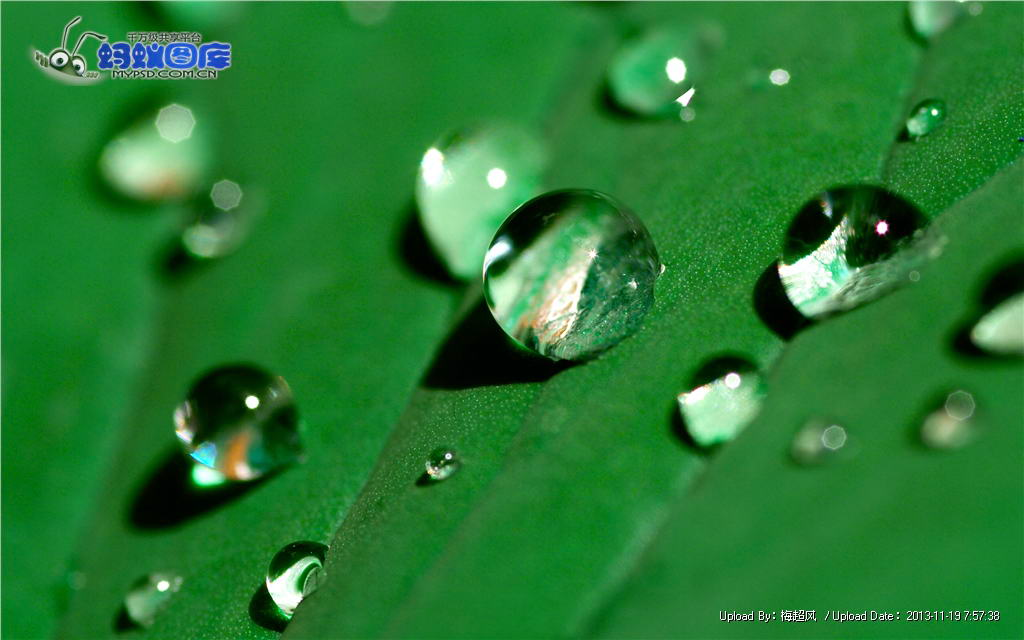

In [ ]:
img = cv2.imread(str(weather_dict['dew'][1]))
img.shape
Image.fromarray(img)

In [ ]:
IMAGE_SIZE =(400,400)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 20,
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False
)


# Create minibatches that flow from directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    batch_size = BATCH_SIZE,
    class_mode = 'sparse',
    shuffle = True
)



# create test generator for evaluation
test_datagen = ImageDataGenerator(
    rescale = 1/255.0
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'sparse',
    batch_size = 16,
    shuffle = False   # IMPORTANT, don't shuffle in this case
)

Found 4851 images belonging to 11 classes.
Found 1178 images belonging to 11 classes.


In [ ]:
densenetmodel = keras.applications.DenseNet169(weights='imagenet', include_top=False,input_shape=(400,400,3), classes =11)

layer_dict = dict([(layer.name, layer) for layer in densenetmodel.layers])
x = layer_dict['pool4_conv'].output


x=keras.layers.Flatten()(x)
x=Dense(100, activation='relu')(x)
predictions = Dense(11, activation='softmax')(x)

model=Model(densenetmodel.input, predictions)
model.summary()

51888128/51877672 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 406, 406, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 200, 200, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:
for layers in model.layers [:52]:
    layers.trainable = False

In [ ]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy" ])

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
trial = model.fit(train_generator, epochs=10,shuffle =True)

Epoch 1/10
 68/152 [============>.................] - ETA: 11:56 - loss: 0.6613 - accuracy: 0.7966

KeyboardInterrupt: ignored

In [ ]:
model.save('/contents/drive/MyDrive/Envision/Models/Densenet_model.h5')

In [ ]:
# get metrics on test data and print
metrics = model.evaluate(test_generator, return_dict = True)
for metric in metrics:
  print(f"{metric} : {metrics[metric]}")

In [ ]:
# get probabalistic predictions and convert them to classes
predictions = model.predict(test_generator)


In [ ]:
predictions = np.asarray([1 if i[0]>=0.5 else 0 for i in predictions])
classes = test_generator.labels
print("got predictions and classes")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
names=('dew',
    'fogsmog'
    'frost',
    'glaze',
    'hail',
    'lightning',
    'rain',
    'rainbow',
    'rime',
    'sandstorm',
    'snow')
Y_pred = model.predict(x_test)

print(classification_report(y_test, np.argmax(Y_pred, axis=1),target_names=names))


cm=confusion_matrix(y_test, np.argmax(Y_pred, axis=1))
print(cm)

In [ ]:
!pip install pretty-confusion-matrix

In [ ]:
plt.figure(figsize=(20,20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
disp.plot()
plt.show()

from sklearn.metrics import classification_report,confusion_matrix
import itertools
from pretty_confusion_matrix import pp_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
names=('WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING')

print(classification_report(np.argmax(ytest,axis=1), np.argmax(predictions, axis=1),target_names=names))


cm=confusion_matrix(np.argmax(ytest,axis=1), np.argmax(predictions, axis=1))
df_cm = pd.DataFrame(cm, index=range(1, 7), columns=range(1, 7))
# colormap: see this and choose your more dear
cmap = 'PuRd'
pp_matrix(df_cm, cmap=cmap)